In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_reviews = pd.read_csv('bluemovement.csv')
df_reviews.head()

,Unnamed: 0,review_title,review_date,review_text,page_number,rating,title_text_concatenated,title_text_translated
0,0,It was a breeze booking the Washing…,2022-06-11,It was a breeze booking the Washing machine fr...,1,4,It was a breeze booking the Washing machine fr...,It was a breeze booking the Washing machine fr...
1,1,Alles is subliem afgeleverd .Perfect,2022-05-28,Alles is subliem afgeleverd .,1,5,Alles is subliem afgeleverd . Alles is subliem...,Everything was delivered perfectly . Everythin...
2,2,Very bad company,2022-05-27,Very bad company. Paying way too much for even...,1,1,Very bad company. Paying way too much for even...,Very bad company. Paying way too much for even...
3,3,I really enjoyed the service,2022-05-18,"I really enjoyed the service, quite fast and p...",1,5,"I really enjoyed the service, quite fast and p...","I really enjoyed the service, quite fast and p..."
4,4,Very fast service,2022-05-13,"Very fast service , the drivers were very fast...",1,5,"Very fast service , the drivers were very fast...","Very fast service , the drivers were very fast..."


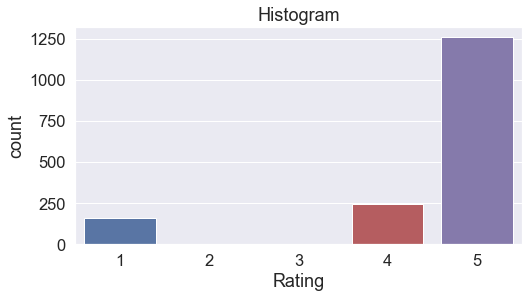

In [161]:
plt.figure(figsize=(8, 4))
sns.countplot(x='rating', data=df_reviews)
plt.xlabel("Rating")
plt.title("Histogram")
plt.show()

In [4]:
df_reviews = df_reviews[~df_reviews['title_text_translated'].isnull()]

def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')  
    return ReviewText

df_reviews['title_text_translated'] = preprocess(df_reviews['title_text_translated'])

In [5]:
# Using TextBlob to calculate sentiment polarity which lies in the range of [-1,1] 
# where 1 means positive sentiment and -1 means a negative sentiment
df_reviews['polarity'] = df_reviews['title_text_translated'].map(lambda text: TextBlob(text).sentiment.polarity)

# Create new feature for the length of the review
df_reviews['review_len'] = df_reviews['title_text_translated'].astype(str).apply(len)

# Create new feature for the word count of the review
df_reviews['word_count'] = df_reviews['title_text_translated'].apply(lambda x: len(str(x).split()))

In [11]:
df_reviews.polarity.describe()

count    1670.000000
mean        0.450739
std         0.398653
min        -0.609848
25%         0.265833
50%         0.495833
75%         0.750000
max         1.000000
Name: polarity, dtype: float64

In [12]:
df_reviews.review_len.describe()

count    1670.000000
mean      110.529341
std        90.037234
min        13.000000
25%        25.250000
50%        83.000000
75%       184.000000
max       542.000000
Name: review_len, dtype: float64

In [13]:
df_reviews.word_count.describe()

count    1670.000000
mean       18.514970
std        16.275252
min         1.000000
25%         4.000000
50%        13.000000
75%        32.000000
max        90.000000
Name: word_count, dtype: float64

In [26]:
print('3 random reviews with the positive sentiment polarity: \n')
cl = df_reviews.loc[df_reviews.polarity > 0.8, ['title_text_translated']].sample(3).values
for c in cl:
    print(c[0])

3 random reviews with the highest positive sentiment polarity: 

Everything was delivered perfectly . Everything was delivered perfectly.perfect
The service was great and the washing machine works wonderful! Works perfectly well
 It's perfect service 👌


In [91]:
print('3 random reviews with the negative sentiment polarity: \n')
cl = df_reviews.loc[df_reviews.polarity < -0.2, ['title_text_translated']].sample(3).values
for c in cl:
    print(c[0])

3 random reviews with the negative sentiment polarity: 

Very bad company. Paying way too much for even 2nd hand stuff.Should be criminal!! Very bad company
Very bad company. Paying way too much for even 2nd hand stuff.Should be criminal!! Very bad company
Total bad information Disinformation peoples Total bad information


<AxesSubplot:title={'center':'Sentiment Polarity Distribution'}, ylabel='Frequency'>

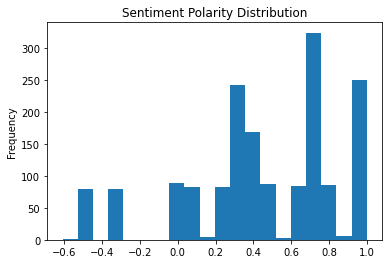

In [95]:
df_reviews['polarity'].plot(
    kind='hist',
    bins=20,
    xlabel='polarity',
    ylabel='count',
    title='Sentiment Polarity Distribution')

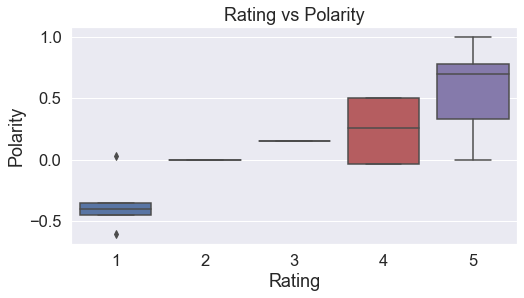

In [157]:
plt.figure(figsize = (8, 4))
sns.set_style('whitegrid')
sns.set(font_scale = 1.5)
sns.boxplot(x = 'rating', y = 'polarity', data = df_reviews)
plt.xlabel("Rating")
plt.ylabel("Polarity")
plt.title("Rating vs Polarity")
plt.show()

<AxesSubplot:title={'center':'Review Text Length Distribution'}, ylabel='Frequency'>

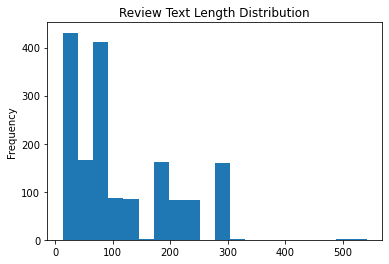

In [99]:
df_reviews['review_len'].plot(
    kind='hist',
    bins=20,
    xlabel='review length',
    ylabel='count',
    title='Review Text Length Distribution')

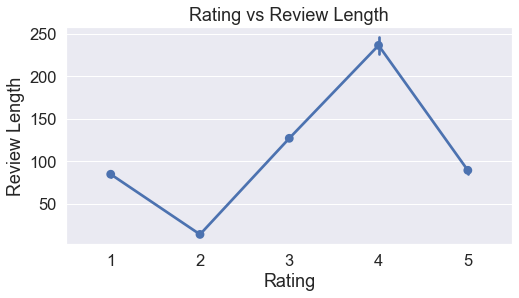

In [154]:
plt.figure(figsize=(8, 4))
sns.pointplot(x = "rating", y = "review_len", data = df_reviews)
plt.xlabel("Rating")
plt.ylabel("Review Length")
plt.title("Rating vs Review Length")
plt.show()

<AxesSubplot:title={'center':'Review Text Word Count Distribution'}, ylabel='Frequency'>

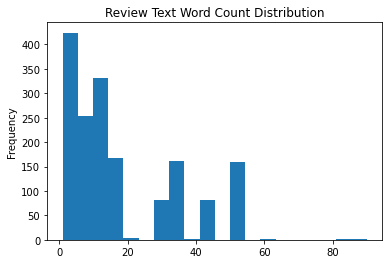

In [100]:
df_reviews['word_count'].plot(
    kind='hist',
    bins=20,
    xlabel='word count',
    ylabel='count',
    title='Review Text Word Count Distribution')

<AxesSubplot:title={'center':'Top 20 words in review before removing stop words'}, xlabel='title_text_translated', ylabel='Count'>

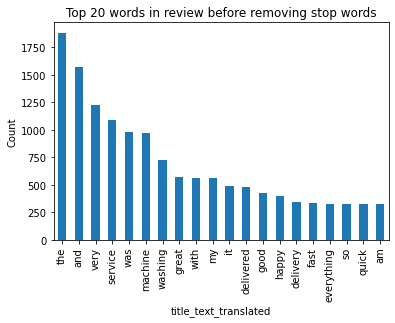

In [105]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df_reviews['title_text_translated'], 20)

df1 = pd.DataFrame(common_words, columns = ['title_text_translated' , 'count'])
df1.groupby('title_text_translated').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', ylabel='Count', title='Top 20 words in review before removing stop words')

<AxesSubplot:title={'center':'Top 20 words in review after removing stop words'}, xlabel='title_text_translated', ylabel='Count'>

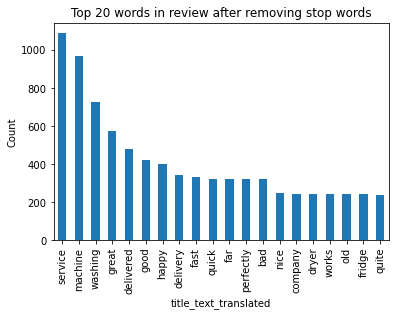

In [106]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df_reviews['title_text_translated'], 20)

df2 = pd.DataFrame(common_words, columns = ['title_text_translated' , 'count'])
df2.groupby('title_text_translated').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', ylabel='Count', title='Top 20 words in review after removing stop words')

<AxesSubplot:title={'center':'Top 20 bigrams in review before removing stop words'}, xlabel='title_text_translated', ylabel='Count'>

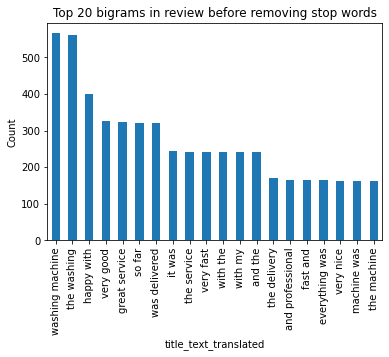

In [107]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df_reviews['title_text_translated'], 20)

df3 = pd.DataFrame(common_words, columns = ['title_text_translated' , 'count'])
df3.groupby('title_text_translated').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', ylabel='Count', title='Top 20 bigrams in review before removing stop words')

<AxesSubplot:title={'center':'Top 20 bigrams in review after removing stop words'}, xlabel='title_text_translated', ylabel='Count'>

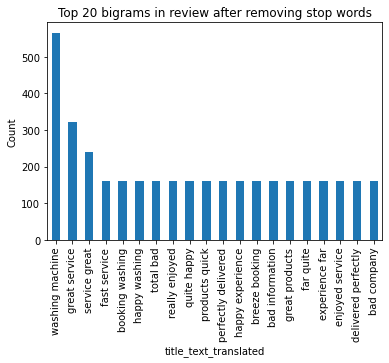

In [108]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df_reviews['title_text_translated'], 20)

df4 = pd.DataFrame(common_words, columns = ['title_text_translated' , 'count'])
df4.groupby('title_text_translated').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', ylabel='Count', title='Top 20 bigrams in review after removing stop words')

<AxesSubplot:title={'center':'Top 20 trigrams in review before removing stop words'}, xlabel='title_text_translated', ylabel='Count'>

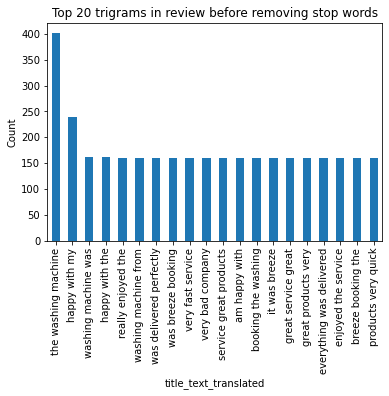

In [109]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(df_reviews['title_text_translated'], 20)

df5 = pd.DataFrame(common_words, columns = ['title_text_translated' , 'count'])
df5.groupby('title_text_translated').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', ylabel='Count', title='Top 20 trigrams in review before removing stop words')

<AxesSubplot:title={'center':'Top 20 trigrams in review after removing stop words'}, xlabel='title_text_translated', ylabel='Count'>

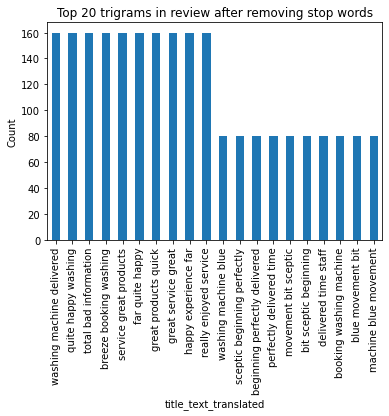

In [110]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(df_reviews['title_text_translated'], 20)

df6 = pd.DataFrame(common_words, columns = ['title_text_translated' , 'count'])
df6.groupby('title_text_translated').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', ylabel='Count', title='Top 20 trigrams in review after removing stop words')

<AxesSubplot:title={'center':'Top 20 Part-of-speech tagging for review corpus'}, xlabel='POS', ylabel='count'>

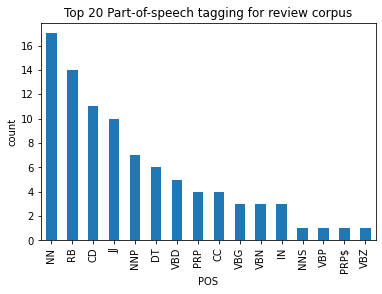

In [111]:
import nltk

blob = TextBlob(str(df_reviews['title_text_translated']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.plot(
    kind='bar',
    xlabel='POS',
    ylabel='count', 
    title='Top 20 Part-of-speech tagging for review corpus')

In [115]:
# Wordcloud
from wordcloud import WordCloud

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

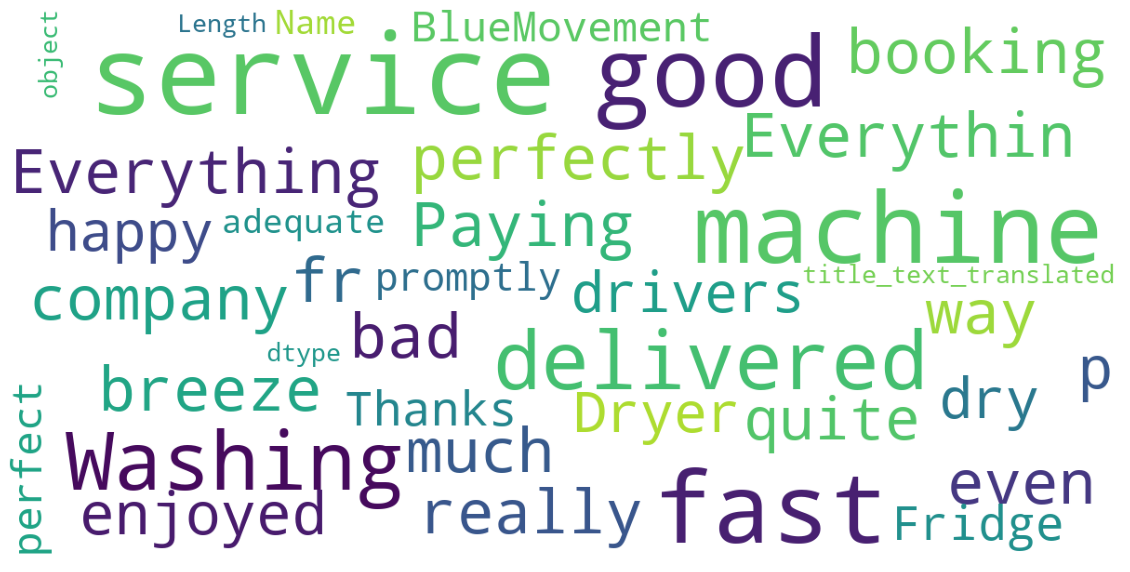

In [120]:
# print wordcloud
show_wordcloud(df_reviews["title_text_translated"])

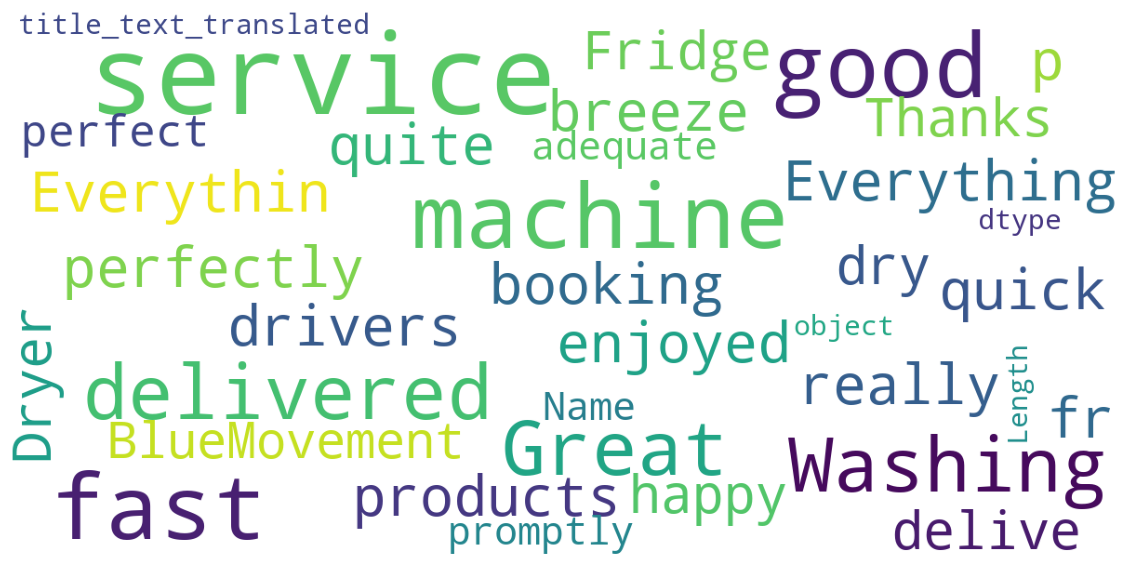

In [121]:
# print wordcloud for positive ratings
show_wordcloud(df_reviews[df_reviews['rating'] > 3]["title_text_translated"])

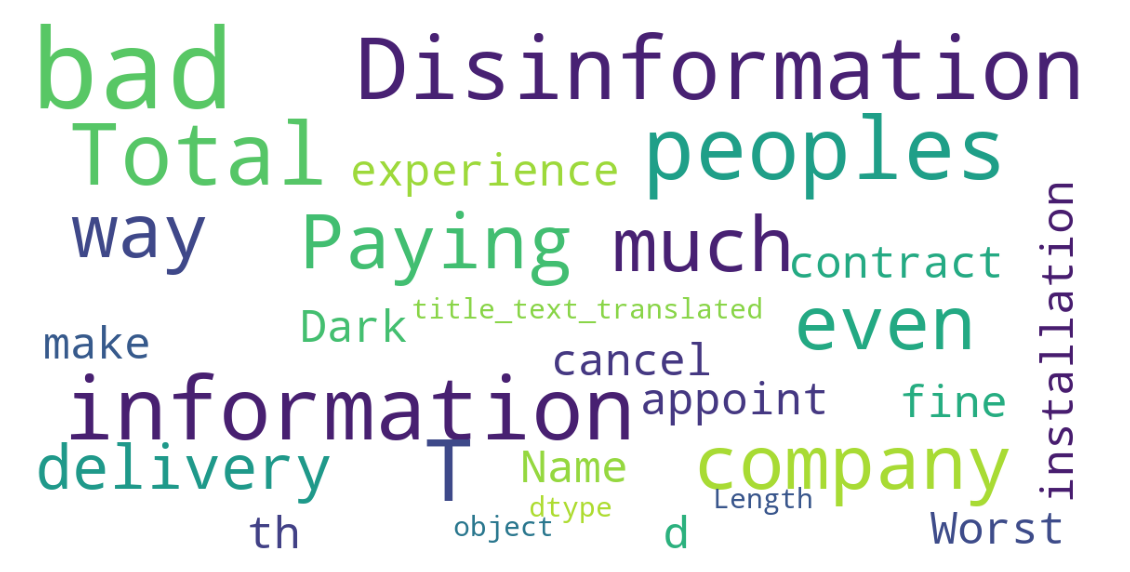

In [122]:
# print wordcloud for negative ratings
show_wordcloud(df_reviews[df_reviews['rating'] <= 3]["title_text_translated"])